<center>
    <h3>Pattern Recognition Lab</h3>
    <hr>
    <br>
    <div style="margin:0 60px 0px 0">
        <img src="https://www5.cs.fau.de/images/lme.jpg" alt="PA" width=150px align=center>
    </div>
    <h1>Style Classification in Posters</h1>
    <h2>Exploratory Data Analysis (EDA)</h2>
    <hr>
    <h3>Tim Löhr</h3>
    <br>
</center>

>  
      - Style classification using WikiArt
      - Crawl WikiArt (images+styles)
      - Train DL-based network w. WikiArt data
      - Apply to poster data

**Table of Contents** `(clickable)`
- [1.0 - Data Loading](#1)
- [2.0 - Generate Pandas DataFrame](#2)
- [3.0 - Generate Pandas DataFrame](#3)
- [4.0 - Data Analysis](#4)
    - [4.1 - Artworks distribution](#4.1)
    - [4.2 - Year distribution](#4.2)
    - [4.3 - Style distribution](#4.3)
    - [4.4 - Style distribution](#4.4)
- [5.0 - Conclusion](#5)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import os
import sys
import requests

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

<a name='1'></a>

## (1) Data Loading

In [2]:
meta_data_path = os.path.join("..","..", "Data", "wikiart", "meta")
root_dir = os.path.join("..", "..", "Data", "wikiart", "images")
csv_path = os.path.join("..", "..", "Data", "wikiart.csv")

meta_dictionary = {}

for artist in os.listdir(meta_data_path):
    artist_path = os.path.join(meta_data_path, artist)
    
    try:
        with open(artist_path, "rb") as file:
            json_file = json.load(file)
            artist = artist.split('.')[0]
            meta_dictionary[artist] = {}

            for i, artwork in enumerate(json_file):
                meta_dictionary[artist][i] = {}
                for j, feature in enumerate(artwork):
                    if feature == "image":
                        artwork[feature] = artwork[feature][:-10]

                    meta_dictionary[artist][i][feature] = artwork[feature]
                    
    except:
        pass
                
print(f"Number of Artists: {len(meta_dictionary)}")

Number of Artists: 734


<a name='2'></a>

## (2) Generate Pandas DataFrame

In [3]:
important_features = ['contentId', 'artistName', 'artistUrl','yearAsString', 'style', 'genre', 'tags', 'url']

In [ ]:
try:
    
    df = pd.read_csv(csv_path)
    print(f"DataFrame successfully loaded. Dataframe Shape: {df.shape}")
except:
    
    # prepare unique features for the pandas df
    features = []
    for artist in meta_dictionary:
        for art in meta_dictionary[artist]:
            feats = list(meta_dictionary[artist][art].keys())
            features = np.concatenate([features, feats])

    unique_features = np.unique(features)
    print(f"Unique Features: {len(unique_features)}")
    
    # create pandas df based on that
    df = pd.DataFrame(columns=unique_features)

    # fill in features if it exist
    for artist in meta_dictionary:
        for art in meta_dictionary[artist]:
            feats = meta_dictionary[artist][art]
            df = df.append(feats, ignore_index=True)

    # Preprocessing
    df = df.replace('', np.nan)
    df = df.replace('None','')
    
    cleaned_df = pd.concat([df[important_features], df['style'].str.split(',', expand=True).rename(columns={0: "Style_1", 1: 'Style_2'})], axis=1).drop(columns=['style']).copy()
    
    cleaned_df = cleaned_df.dropna(subset=["Style_1", "genre"]).copy()

    cleaned_df['Style_1'] = cleaned_df['Style_1'].astype(str).str.strip()
    cleaned_df['Style_2'] = cleaned_df['Style_2'].astype(str).str.strip()

    cleaned_df.loc[cleaned_df['Style_1'].str.contains('Neo-Pop Art'), "Style_1"] = "Pop Art"
    cleaned_df.loc[cleaned_df['Style_2'].str.contains('Neo-Pop Art'), "Style_2"] = "Pop Art"
    cleaned_df['genre'] = cleaned_df['genre'].apply(lambda x: x.split(',')[0])
    cleaned_df = cleaned_df.drop("Style_2", axis=1).rename(columns={"Style_1": "style"}).copy()

    # for dataloader
    cleaned_df['path'] = cleaned_df.apply(lambda x: str(x['artistUrl']) + "/" + str(x['yearAsString']) + "/" + str(x['contentId']) + ".jpg", axis=1)
    cleaned_df.drop(["contentId", "artistUrl", "url", "yearAsString"], axis=1, inplace=True)
    print(f"Dataset successfully generated: DataFrame Shape: {df.shape}")

<a name='3'></a>

## (3) Check if image exists

In [ ]:
dropped_df = cleaned_df.copy()
dropped_df = dropped_df.reset_index().drop('index', axis=1)

print(f"DataFrame shape before drop: {cleaned_df.shape}")

for i, filename in enumerate(cleaned_df['path']):
    path = os.path.join(root_dir, filename)
    
    if not os.path.isfile(path):
        dropped_df.drop(index=i, inplace=True)
        
print(f"DataFrame shape after drop: {dropped_df.shape}")

In [32]:
df = dropped_df.copy()
df.to_csv(csv_path, index=False)
print("DataFrame successfully saved.")

DataFrame successfully saved.


<a name='4'></a>

## (4) Data Analysis

In [34]:
important_features = df.columns

for feature in important_features:
    print(f"{feature} - Number of unique features: {len(df[feature].unique())}")

artistName - Number of unique features: 557
genre - Number of unique features: 52
tags - Number of unique features: 12501
style - Number of unique features: 133
path - Number of unique features: 23205


In [35]:
images_per_artist = []

for artist in meta_dictionary:
    images_per_artist.append(len(artist))

<a name='4.1'></a>

### (4.1) Artworks distribution

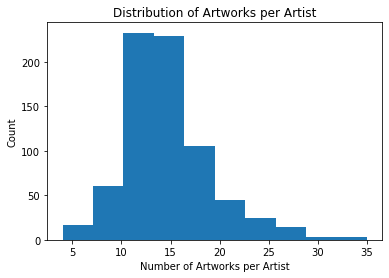

In [36]:
plt.hist(images_per_artist)
plt.xlabel("Number of Artworks per Artist")
plt.ylabel("Count")
plt.title("Distribution of Artworks per Artist")
plt.show()

<a name='4.2'></a>

### (4.2) Year distribution

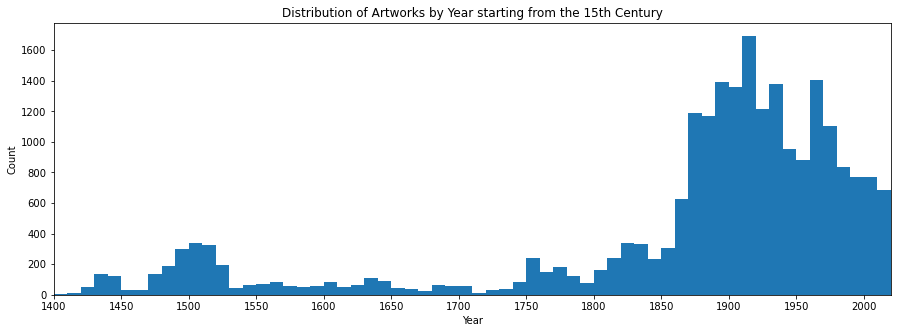

In [43]:
data = df['path'].apply(lambda x: x.split("/")[1]).dropna().astype(int)
binwidth = 10

plt.figure(figsize=(15,5))
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
plt.xticks(np.arange(min(data), max(data)+1, 50))
plt.xlim(1400, 2020)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Distribution of Artworks by Year starting from the 15th Century")
plt.show()

<a name='4.3'></a>

### (4.3) Style distribution

In [ ]:
style_count_df = df['style'].value_counts()

data = style_count_df
binwidth = 50

plt.figure(figsize=(15,5))
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
plt.xticks(np.arange(min(data)-1, max(data), 50))
plt.xlim(1, 500)
plt.xlabel("Amount of the style")
plt.ylabel("Count")
plt.title("Distribution of styles [0 to 500] different styles")
plt.show()

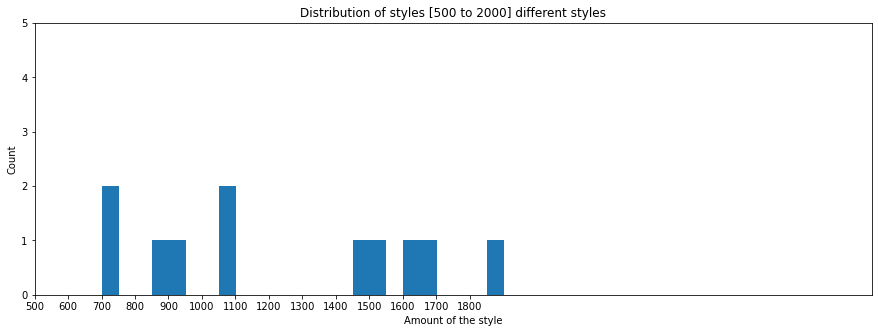

In [56]:
data = style_count_df
binwidth = 50

plt.figure(figsize=(15,5))
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
plt.xticks(np.arange(min(data)-1, max(data), 100))
plt.xlim(500, 3000)
plt.ylim(0, 5)
plt.xlabel("Amount of the style")
plt.ylabel("Count")
plt.title("Distribution of styles [500 to 2000] different styles")
plt.show()

<a name='4.4'></a>

### (4.4) Genre distribution

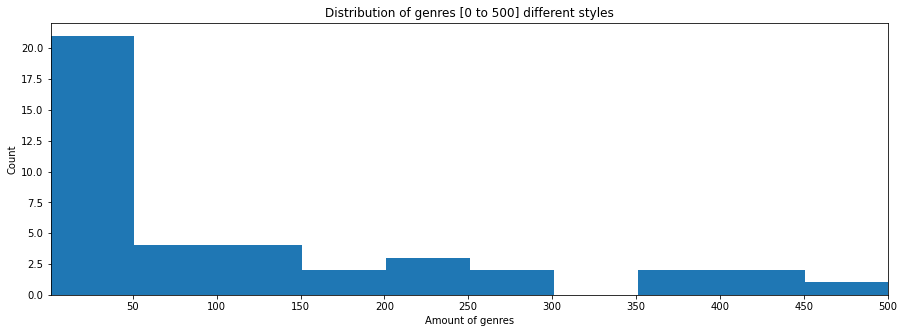

In [59]:
genre_count_df = df['genre'].value_counts()
data = genre_count_df
binwidth = 50

plt.figure(figsize=(15,5))
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
plt.xticks(np.arange(min(data)-1, max(data), 50))
plt.xlim(1, 500)
plt.xlabel("Amount of genres")
plt.ylabel("Count")
plt.title("Distribution of genres [0 to 500] different styles")
plt.show()

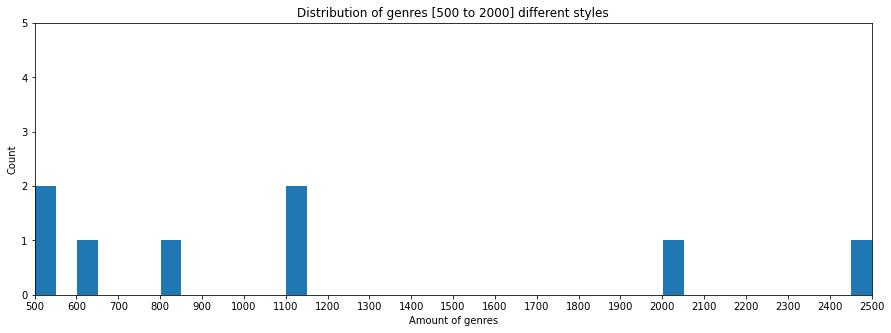

In [60]:
binwidth = 50

plt.figure(figsize=(15,5))
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
plt.xticks(np.arange(min(data)-1, max(data), 100))
plt.xlim(500, 2500)
plt.ylim(0, 5)
plt.xlabel("Amount of genres")
plt.ylabel("Count")
plt.title("Distribution of genres [500 to 2000] different styles")
plt.show()

In [61]:
style_df = df[df['style'].str.contains('Pop')]


print(f"Style_1 - Pop Art pictures in total: {len(style_df['style'])}")
print(f"Style_1 - Pop Art variations in total: {len(np.unique(list(style_df['style'])))}")
print()
print(f"Poster occurence in genre: {len(df[df['genre'].str.contains('poster')])}")

Style_1 - Pop Art pictures in total: 407
Style_1 - Pop Art variations in total: 1

Poster occurence in genre: 77


<a name='5'></a>


## (5) Conclusion:

Most of the genres and styles occured less than 50 times in total for this entire dataset. We have a high class-imbalance problem. 

- **Import styles for posters are e.g. Pop-Art, which occures in total only 407 times in the dataset **
- **Import genres for posters are e.g. poster, which occures in total only 77 times in the dataset **

Therefore building a proper Train and Test set is very important.

`Year`
- Most pictures are from 1850 until 1900

`Style`
- The 5 most common genres are:
    - Impressionism (2561)
    - Neoclassicism (2183)
    - Expressionism (2178)
    - Realism (2136)
    - Romanticism (2109)

`Genre`
- The 5 most common genres are:
    - landscape (4999)
    - portrait (4550)
    - genre painting (3692)	
    - abstract (3484)
    - religious painting (2368)	